# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from clean_data import clean_data
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# Load feature info
feat_info = pd.read_csv('features.csv')
feat_info.set_index('attribute', inplace=True)

# Parse missing_or_known string into a list
def parse_missing(s):
    a = s[1:-1].split(',')
    return a

feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(parse_missing)

In [2]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\Mei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [76]:
azdias.shape

(891221, 366)

In [77]:
customers.shape

(191652, 369)

In [78]:
feat_info.head()

,information_level,type,missing_or_unknown,Comment
attribute,,,,
AGER_TYP,person,categorical,"[-1, 0]",NaN
ALTER_HH,household,interval,[0],NaN
ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]",NaN
ANREDE_KZ,person,categorical,"[-1, 0]",NaN
ANZ_HAUSHALTE_AKTIV,building,numeric,[0],NaN


### Check and handle missing values

In [79]:
# Check uncoded missing values
p_missing = azdias.isnull().mean()

In [80]:
p_missing.sort_values(ascending=False).head()

ALTER_KIND4    0.998648
ALTER_KIND3    0.993077
ALTER_KIND2    0.966900
ALTER_KIND1    0.909048
EXTSEL992      0.733996
dtype: float64

In [81]:
# Find the columns not covered by feature info
missing_from_feat_info = set(azdias.columns.values).difference(feat_info.index.values)
list(missing_from_feat_info)[:12]

['EINGEZOGENAM_HH_JAHR',
 'ALTER_KIND1',
 'CJT_TYP_6',
 'D19_VERSI_ONLINE_QUOTE_12',
 'EINGEFUEGT_AM',
 'CJT_TYP_3',
 'D19_LETZTER_KAUF_BRANCHE',
 'STRUKTURTYP',
 'D19_SOZIALES',
 'RT_KEIN_ANREIZ',
 'ALTER_KIND3',
 'CJT_TYP_5']

In [82]:
azdias.drop(list(missing_from_feat_info), axis='columns', inplace=True)

In [83]:
# Find columns not in the dataset
missing_azdias = set(feat_info.index.values).difference(azdias.columns.values)
missing_azdias

{'BIP_FLAG',
 'GEOSCORE_KLS7',
 'HAUSHALTSSTRUKTUR',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB'}

In [84]:
# Convert missing values to Nans
missing_values = pd.Series(feat_info['missing_or_unknown'].values, index=feat_info.index).to_dict()
azdias[azdias.isin(missing_values)] = np.nan

#### Missing values by column

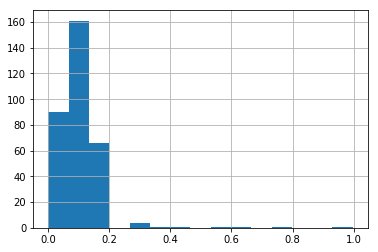

In [86]:
p_missing = azdias.isnull().mean()

p_missing.hist(bins=15);

In [87]:
p_threshold = 0.2
to_drop = p_missing[p_missing > p_threshold]
to_drop.index

Index(['AGER_TYP', 'ALTER_HH', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_VERSAND_ONLINE_QUOTE_12', 'GEBURTSJAHR', 'KBA05_BAUMAX',
       'KK_KUNDENTYP', 'TITEL_KZ'],
      dtype='object')

In [88]:
p_missing.D19_KONSUMTYP

0.2884952217239046

In [89]:
# Drop columns below acceptable threshold of missing values
azdias = azdias.drop(to_drop.index, axis='columns')

In [90]:
azdias.columns

Index(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'ARBEIT', 'BALLRAUM',
       'CAMEO_DEU_2015', 'CAMEO_DEUG_2015',
       ...
       'SHOPPER_TYP', 'SOHO_KZ', 'UNGLEICHENN_FLAG', 'VERS_TYP',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=317)

#### Missing Values by Row

In [91]:
missing_by_row = azdias.isnull().sum(axis=1)

(array([7.37287e+05, 1.00000e+00, 3.84820e+04, 9.65100e+03, 0.00000e+00,
        5.82100e+03, 2.00000e+00, 5.43000e+02, 6.28300e+03, 9.31510e+04]),
 array([  0. ,  22.7,  45.4,  68.1,  90.8, 113.5, 136.2, 158.9, 181.6,
        204.3, 227. ]),
 <a list of 10 Patch objects>)

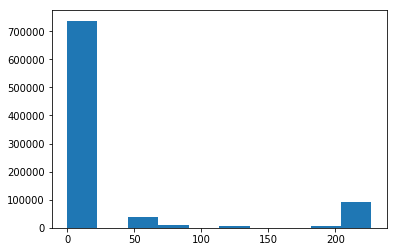

In [92]:
plt.hist(missing_by_row)

(array([612216.,  10387.,  32065.,  16359.,  13132.,   2775.,  21858.,
          9789.,  11137.,   5853.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

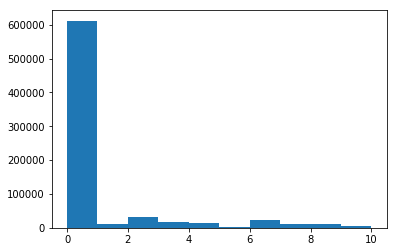

In [93]:
plt.hist(missing_by_row, range=(0,10))

In [94]:
missing_by_row.value_counts().sort_index().head(11)

0     612216
1      10387
2      32065
3      16359
4      13132
5       2775
6      21858
7       9789
8      11137
9        761
10      5092
dtype: int64

In [95]:
# Only take rows at or below threshold
threshold = 10

azdias_below = azdias[missing_by_row <= threshold]
print(azdias_below.shape[0])

azdias_above = azdias[missing_by_row > threshold]
print(azdias_above.shape[0])

735571
155650


In [96]:
print(azdias_above.shape[0]/azdias.shape[0])

0.17464803903857742


In [97]:
def do_comparison_plots(subset1, subset2, subtitle1, subtitle2, column_name):
#    f, (ax1, ax2) = plt.subplots(1, 2, sharey='row', figsize=(10, 4))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    sns.countplot(subset1[column_name], ax=ax1)
    sns.countplot(subset2[column_name], ax=ax2)
    
    ax1.set_title(subtitle1)
    ax2.set_title(subtitle2)
    
    plt.subplots_adjust(wspace=.25)
    plt.show()

Threshold =  10


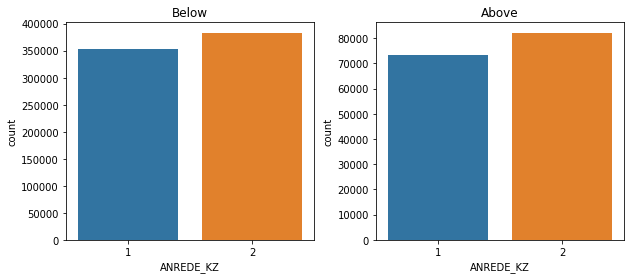

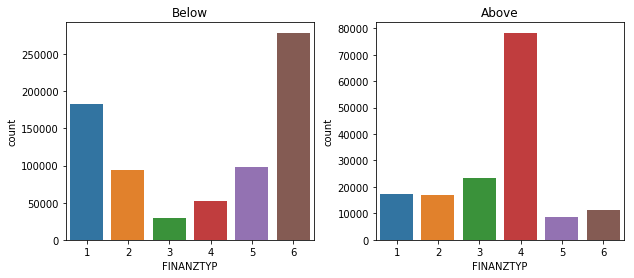

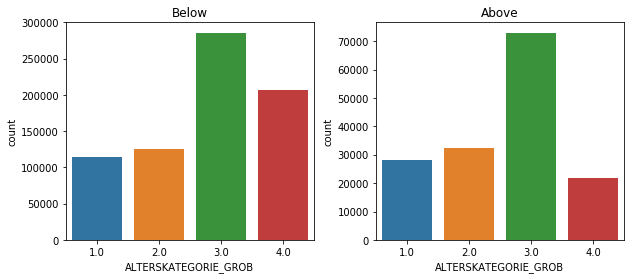

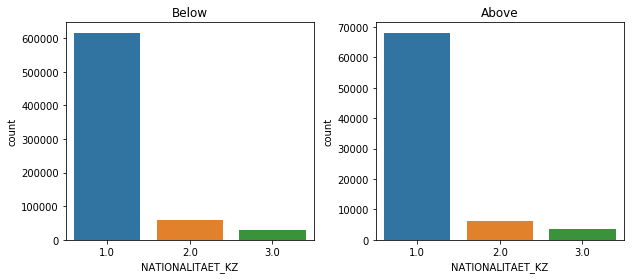

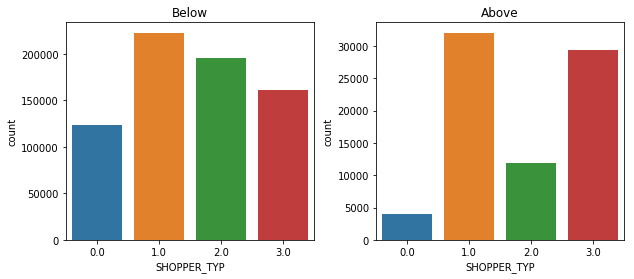

In [98]:
print("Threshold = ", threshold)
for col in ['ANREDE_KZ', 'FINANZTYP', 'ALTERSKATEGORIE_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP']:
    do_comparison_plots(azdias_below, azdias_above, 'Below', 'Above', col)

At a threshold of 0 (no missing values), 31% of the data is dropped and there are differences in FINANZTYP (finance type), ALTERSKATEGORIE_GROB (age category), and SHOPPER_TYPE. At a threshold of 10, 17.5% is dropped. And at 25, 17% is dropped.
<p>
Increasing the threshold does not remove the differences in the above features.

In [99]:
azdias = azdias_below

#### Re-Encode Categorical Features

In [100]:
feat_info.type.value_counts()

ordinal        270
categorical     42
numeric          9
binary           6
mixed            4
interval         1
Name: type, dtype: int64

In [101]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical = feat_info[feat_info['type'] == 'categorical']
print('Number of orig. categorical variables: ', len(categorical))

Number of orig. categorical variables:  42


In [102]:
categorical = categorical[categorical.index.isin(azdias.columns)]
print('Number of categorical variables currently: {}\n'.format(len(categorical)))

for col in categorical.index:
    print(col, azdias[col].unique())

Number of categorical variables currently: 35

ANREDE_KZ [2 1]
CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '7A' '5D' '9E' '5C'
 '9B' '1B' '8B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6E' '6D' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']
CAMEO_DEUG_2015 [8.0 4.0 2.0 6.0 1.0 9.0 7.0 5.0 3.0 nan '3' '7' '2' '4' '9' '6' '8' '5'
 '1']
CJT_GESAMTTYP [ 5.  3.  2.  4.  1.  6. nan]
D19_BANKEN_DATUM [10  5  8  9  7  4  6  1  2  3]
D19_BANKEN_OFFLINE_DATUM [10  9  8  2  5  4  1  6  7  3]
D19_BANKEN_ONLINE_DATUM [10  5  8  9  4  7  6  1  2  3]
D19_GESAMT_DATUM [10  1  3  5  9  7  6  8  2  4]
D19_GESAMT_OFFLINE_DATUM [10  6  8  9  5  2  4  1  7  3]
D19_GESAMT_ONLINE_DATUM [10  1  3  5  9  7  6  8  2  4]
D19_TELKO_DATUM [10  6  9  8  5  7  4  2  1  3]
D19_TELKO_OFFLINE_DATUM [10  8  5  6  9  7  4  3  2  1]
D19_TELKO_ONLINE_DATUM [10  9  7  8  6  5  4  1  2  3]
D19_VERSAND_DATUM [10  1  5  9  8  6  3  2  4  7]
D19_VERSAND_OFFLINE_D

In [103]:
# recode 10's to 0 for D19 columns
recode = categorical[categorical.index.str.startswith('D19_')].index.values
recode

array(['D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM'], dtype=object)

In [104]:
azdias[recode] = azdias[recode].replace(10, 0)

In [105]:
azdias.D19_BANKEN_OFFLINE_DATUM.value_counts()

0    717698
8      5904
9      4671
5      3913
2      1864
6       470
1       407
7       304
4       280
3        60
Name: D19_BANKEN_OFFLINE_DATUM, dtype: int64

In [106]:
categorical.drop(recode, axis='rows', inplace=True)

In [107]:
# Drop all fine scale variables in favor of the rough scale version
drop = ['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN']
azdias.drop(drop, axis=1, inplace=True)

In [108]:
categorical.drop(drop, axis='rows', inplace=True)

In [109]:
# convert CAMEO_DEUG_2015 from string to float
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype(float)
azdias['CAMEO_DEUG_2015'].unique()

array([ 8.,  4.,  2.,  6.,  1.,  9.,  7.,  5.,  3., nan])

In [110]:
for col in categorical.index:
    print(col, azdias[col].unique())

ANREDE_KZ [2 1]
CAMEO_DEUG_2015 [ 8.  4.  2.  6.  1.  9.  7.  5.  3. nan]
CJT_GESAMTTYP [ 5.  3.  2.  4.  1.  6. nan]
FINANZTYP [1 6 5 2 4 3]
GEBAEUDETYP [8. 1. 3. 2. 6. 4. 5.]
GFK_URLAUBERTYP [10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6. nan]
GREEN_AVANTGARDE [0 1]
LP_FAMILIE_GROB [ 3.  1. nan  5.  2.  4.]
LP_STATUS_GROB [ 1.  2.  4.  5.  3. nan]
NATIONALITAET_KZ [ 1.  3.  2. nan]
OST_WEST_KZ ['W' 'O']
PLZ8_BAUMAX [ 1.  2.  4.  5.  3. nan]
SHOPPER_TYP [ 3.  2.  1.  0. nan]
SOHO_KZ [1. 0.]
VERS_TYP [ 2.  1. nan]
WOHNLAGE [ 4.  2.  7.  3.  5.  1.  8. nan]
ZABEOTYP [5 3 4 1 6 2]


ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, and VERS_TYP are binary and numeric.

OST_WEST_KZ is binary but will need dummy variables.

In [111]:
binary = set(['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP'])
categorical.drop(binary, axis='rows', inplace=True)

In [112]:
# Re-encode categorical variable(s) to be kept in the analysis
to_recode = 'OST_WEST_KZ'
recoded = pd.get_dummies(azdias[to_recode])
recoded.head()

,O,W
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1


In [113]:
# drop the original categorical variables
azdias.drop(to_recode, axis=1, inplace=True)

# add the re-encoded one
azdias = pd.concat([azdias, recoded], axis=1)

print(azdias.columns.size)

315


#### Engineer Mixed-Type Features

In [114]:
feat_info[feat_info['type'] == 'mixed']

,information_level,type,missing_or_unknown,Comment
attribute,,,,
CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]",NaN
LP_LEBENSPHASE_FEIN,person,mixed,[0],NaN
LP_LEBENSPHASE_GROB,person,mixed,[0],NaN
PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]",NaN


In [115]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

print(azdias['PRAEGENDE_JUGENDJAHRE'].head())

# Create decade variable
to_replace = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
azdias['decade'] = azdias['PRAEGENDE_JUGENDJAHRE'].replace(to_replace)
print(azdias['decade'].head())

# Create movement variable
to_replace = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
azdias['movement'] = azdias['PRAEGENDE_JUGENDJAHRE'].replace(to_replace)
print(azdias['movement'].head())

azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64
1    90.0
2    90.0
3    70.0
4    70.0
5    50.0
Name: decade, dtype: float64
1    0.0
2    1.0
3    0.0
4    0.0
5    0.0
Name: movement, dtype: float64


In [116]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias['CAMEO_INTL_2015'].head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [117]:
# Create wealth variable
azdias['wealth'] = azdias.CAMEO_INTL_2015[azdias.CAMEO_INTL_2015.notnull()].map(lambda x: str(x)[0])
print(azdias['wealth'].head())

#life stage
azdias['life_stage'] = azdias.CAMEO_INTL_2015[azdias.CAMEO_INTL_2015.notnull()].map(lambda x: str(x)[1])
print(azdias['life_stage'].head())

azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

1    5
2    2
3    1
4    4
5    5
Name: wealth, dtype: object
1    1
2    4
3    2
4    3
5    4
Name: life_stage, dtype: object


In [59]:
azdias.drop(['LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN'], axis=1, inplace=True)

There are 4 mixed-value features.

Two were kept, PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015.
- PRAEGENDE_JUGENDJAHRE was split into decade and movement. The resulting variables help fill in information that we didn't have. GEBURTSJAHR was dropped because 44% of the data was missing.
- CAMEO_INTL_2015 was split into wealth and life stage. Note: wealth categories ranges from 1 to 5 with 1 denoting wealthy and 5 denoting poorer.

Two features were dropped since the information already exists in other features:
- LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_FEIN represent combined data that is already in the dataset (LP_FAMILIE_X and LP_STATUS_X)

#### Clean data function

In [3]:
# Use data cleaning function that does all of the above
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
print(azdias.shape)

azdias_clean, azdias_dropped = clean_data(azdias, feat_info, row_threshold=10)

C:\Users\Mei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(891221, 366)


In [4]:
print(azdias_clean.shape)
print(azdias_dropped.shape)

(789433, 135)
(101788, 137)


In [4]:
# Test on customer data
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')
print(customers.shape)
customers_clean, customers_dropped = clean_data(customers, feat_info, row_threshold=10)
print(customers_clean.shape)
print(customers_dropped.shape)

(140274, 137)
(51378, 137)


#### Feature Scaling

In [6]:
# Handle remaining missing values
azdias_clean.isnull().mean().sort_values(ascending=False).head(10)

REGIOTYP            0.074951
KKK                 0.074951
W_KEIT_KIND_HH      0.071772
HEALTH_TYP          0.043739
SHOPPER_TYP         0.043739
VERS_TYP            0.043739
MOBI_REGIO          0.042957
NATIONALITAET_KZ    0.040343
HH_DELTA_FLAG       0.039939
LP_FAMILIE_GROB     0.036663
dtype: float64

In [7]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
azdias_impute = imputer.fit_transform(azdias_clean)
print(np.isnan(azdias_impute).sum())

0


In [8]:
# Apply feature scaling to the general population demographics data.
scaler = preprocessing.StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_impute)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### PCA

In [9]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

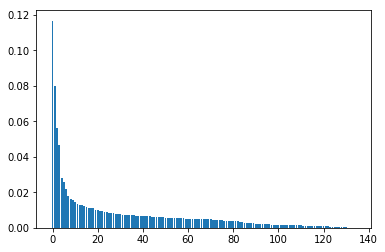

In [10]:
# Investigate the variance accounted for by each principal component.
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
plt.bar(ind, vals)
plt.show()

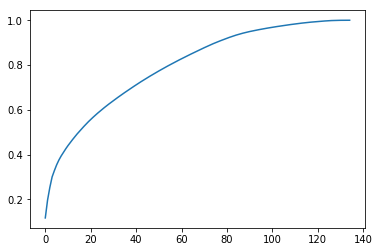

In [11]:
cumvals = np.cumsum(vals)
plt.plot(cumvals)
plt.show()

In [12]:
threshold = .90
i = np.argmax(cumvals > threshold)
print(i, cumvals[i])

76 0.9039389458546735


In [13]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(i)
azdias_pca = pca.fit_transform(azdias_scaled)

#### PCA Interpretation

In [14]:
# Map weights for the principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def print_interesting_features(features, components, i):
    feature_weights = dict(zip(features, components[i]))
    feature_weights_sorted = sorted(feature_weights.items(), key=lambda kv: kv[1])
    print('Lowest:')
    for feature, weight in feature_weights_sorted[:3]:
        print('\t{:20} {:.3f}'.format(feature, weight))
        
    print('Highest:')
    for feature, weight in feature_weights_sorted[-3:]:
        print('\t{:20} {:.3f}'.format(feature, weight))
        

In [15]:
# First principal component
i = 0
print('{:5.2%}'.format(vals[i]))
print_interesting_features(azdias_clean.columns.values, pca.components_, i)

11.67%
Lowest:
	HH_EINKOMMEN_SCORE   -0.151
	CAMEO_DEUG_2015      -0.144
	wealth               -0.142
Highest:
	D19_VERSAND_ANZ_24   0.159
	ONLINE_AFFINITAET    0.167
	D19_GESAMT_ANZ_24    0.173


Lowest:
- HH_EINKOMMEN_SCORE is estimated household net income (1 = highest income)
- CAMEO_DEUG_2015 is CAMEO major classification 2015 (1 = upper class)
- wealth was derived from CAMEO_INTL_2015 (1 = wealthy)

Highest:
- D19_VERSAND_ANZ_24 is transaction activity MAIL-ORDER in the last 12 months (6 = very high activity)
- ONLINE_AFFINITAET is online affinity (5 = highest)
- D19_GESAMT_ANZ_24 is mail-order transaction activity TOTAL POOL in the last 24 months (6 = very high activity)


In [16]:
# Second principal component
i = 1
print('{:5.2%}'.format(vals[i]))
print_interesting_features(azdias_clean.columns.values, pca.components_, i)

7.97%
Lowest:
	ALTERSKATEGORIE_GROB -0.231
	FINANZ_VORSORGER     -0.215
	FINANZ_MINIMALIST    -0.185
Highest:
	SEMIO_REL            0.208
	decade               0.229
	FINANZ_SPARER        0.240


Lowest:
- ALTERSKATEGORIE_GROB is age major category (4	= > 60 years)
- FINANZ_VORSORGER is financial typology: be prepared  (1 = very high)
- FINANZ_MINIMALIST is financial typology: low financial interest (1 = very high)
Highest:
- SEMIO_REL is affinity indicating in what way the person is religious (1 = highest affinity)
- decade was derived from PRAEGENDE_JUGENDJAHRE (1 = 40's, 15 = 90's)
- FINANZ_SPARER is financial typology: money saver (1 = very high)

In [17]:
# Third principal component
i = 2
print('{:5.2%}'.format(vals[i]))
print_interesting_features(azdias_clean.columns.values, pca.components_, i)

5.65%
Lowest:
	SEMIO_KULT           -0.171
	SEMIO_REL            -0.166
	PLZ8_ANTG1           -0.165
Highest:
	EWDICHTE             0.169
	PLZ8_ANTG3           0.170
	ORTSGR_KLS9          0.172


EWDICHTE is population density

### Clustering

In [31]:
# Over a number of different cluster counts...
N = azdias_pca.shape[0]
mean_d = []
centers = range(2, 11)
for k in centers:

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k)
    model = kmeans.fit(azdias_pca)
    
    # compute the average within-cluster distances.
    mean_d.append(abs(model.score(azdias_pca))/N)

[110.47197574256542, 104.73472632240058, 100.95055330321694, 98.81168382584734, 97.15702629483363, 95.58045561485187, 94.29931055085784, 93.07879050786006, 92.0754860722201]


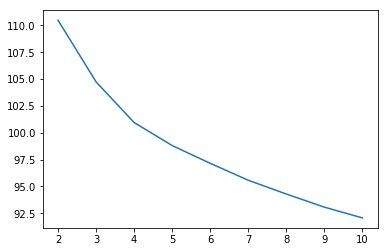

In [32]:
# Investigate the change in within-cluster distance across number of clusters.
print(mean_d)
plt.plot(range(2, len(mean_d) + 2), mean_d);

In [34]:
k = 11

# run k-means clustering on the data and...
kmeans = KMeans(n_clusters=k)
model = kmeans.fit(azdias_pca)

# compute the average within-cluster distances.
mean_d.append(abs(model.score(azdias_pca))/N)

[110.47197574256542, 104.73472632240058, 100.95055330321694, 98.81168382584734, 97.15702629483363, 95.58045561485187, 94.29931055085784, 93.07879050786006, 92.0754860722201, 91.17155676388397]


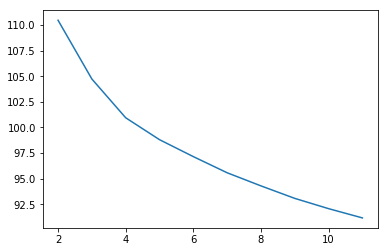

In [35]:
print(mean_d)
plt.plot(range(2, len(mean_d) + 2), mean_d);

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
mailout_train.head()

In [ ]:
mailout_train.RESPONSE.value_counts()

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')